# Optimization with JAX: Gradient Descent and Backtracking

## Laboratory Session

In this laboratory session, we will explore optimization techniques implemented with **JAX**.
We will cover several optimization algorithms:

- Gradient Descent (GD)
- Gradient Descent with Backtracking Line Search
- Exact Line Search for Quadratic Functions

We will apply these methods on various benchmark functions:

- Rastrigin Function
- Ackley Function
- Quadratic Function

Let's begin by importing the rebuired packages.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

## Helper Functions for Plotting

We define a helper function `plot_optimization_2d` to visualize optimization trajectories on a 2D contour plot. This function will:

- Plot the optimization path taken by Gradient Descent (GD)
- Plot the optimization path with Backtracking Line Search if available
- Show the function's value as a contour plot in the background.


In [12]:
def plot_optimization_2d(func, gd_path, gd_backtrack_path, title):
    x_vals = jnp.linspace(-5, 5, 50)
    y_vals = jnp.linspace(-5, 5, 50)
    X, Y = jnp.meshgrid(x_vals, y_vals)
    Z = jnp.array([[func(jnp.array([x, y])) for x in x_vals] for y in y_vals])

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    cs = axs[0].contourf(X, Y, Z, levels=50, cmap="viridis")
    plt.colorbar(cs)
    axs[0].contour(X, Y, Z, colors="white")

    gd_path = jnp.array(gd_path)

    axs[0].plot(gd_path[:, 0], gd_path[:, 1], "r.-", label="GD")

    if gd_backtrack_path != []:
        gd_backtrack_path = jnp.array(gd_backtrack_path)
        axs[0].plot(
            gd_backtrack_path[:, 0],
            gd_backtrack_path[:, 1],
            ".-",
            color="orange",
            label="GD + backtracking",
        )
    axs[0].set_title(title)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].set_ylim([-5, 5])
    axs[0].set_xlim([-5, 5])
    axs[0].legend()

    axs[1].semilogy([func(x) for x in gd_path], "ro-", label="GD")
    axs[1].semilogy(
        [func(x) for x in gd_backtrack_path],
        "o-",
        color="orange",
        label="GD + backtracking",
    )
    axs[1].legend()
    plt.tight_layout()

## Defining Benchmark Functions

### 1. Rastrigin Function

The Rastrigin function is a **non-convex** and **multi-modal** function often used as a test for optimization algorithms.
It is defined as:

$$
f(x) = 10 n + \sum_{i=1}^n \left( x_i^2 - 10 \cos(2 \pi x_i) \right)
$$

with multiple local minima.

### 2. Ackley Function

The Ackley function is another **non-convex** function commonly used in optimization, given by:

$$
f(x) = -20 \exp \left( -0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2} \right) - \exp \left( \frac{1}{n} \sum_{i=1}^n \cos(2 \pi x_i) \right) + 20 + e
$$

### 3. Quadratic Function

The Quadratic function is **convex** and is defined as:

$$
f(x) = \frac{1}{2} x^T A x + b^T x + c
$$


In [19]:
# Define the benchmark functions


# 1. Rastrigin function
@jax.jit
def rastrigin(x):
    return 10 * x.size + jnp.sum(x**2 - 10 * jnp.cos(2 * jnp.pi * x)) + 1e-10


# 2. Ackley function
@jax.jit
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * jnp.pi
    sum1 = jnp.sum(x**2)
    sum2 = jnp.sum(jnp.cos(c * x))
    return (
        -a * jnp.exp(-b * jnp.sqrt(sum1 / x.size))
        - jnp.exp(sum2 / x.size)
        + a
        + jnp.exp(1)
    )


# 3. Quadratic function
quadratic_A = jnp.array([[3.0, 0.5], [0.5, 1.0]])
quadratic_b = jnp.array([-1.0, 2.0])
quadratic_c = jnp.dot(quadratic_b, jnp.linalg.solve(quadratic_A, quadratic_b)) / 2


@jax.jit
def quadratic(x):
    return (
        0.5 * jnp.dot(x.T, jnp.dot(quadratic_A, x))
        + jnp.dot(quadratic_b, x)
        + quadratic_c
    )

## Optimization Algorithms

### Gradient Descent

Gradient Descent is an iterative optimization algorithm defined by:

$$
x_{k+1} = x_k - \eta \nabla f(x_k)
$$

where $ \eta $ is the learning rate.


In [20]:
def gradient_descent(grad_func, x0, lr=0.01, tol=1e-6, max_iter=1000):
    x = x0
    path = [x] # for visualization purposes only
    for _ in range(max_iter):
        grad_val = grad_func(x)
        x = x - lr * grad_val
        path.append(x)

        if jnp.linalg.norm(grad_val) < tol:
            break
    
    return x, path

### Gradient Descent with Backtracking Line Search

Backtracking line search modifies the learning rate $ \eta $ to ensure sufficient decrease.

The key idea is to start with an initial step size and iteratively reduce it until a sufficient decrease condition is met. Specifically, the backtracking process adjusts the step size based on the Armijo condition:

$$
f(x - t \nabla f(x)) \leq f(x) - \alpha t \|\nabla f(x)\|^2
$$

where:

- $ f(x) $ is the objective function,
- $ \nabla f(x) $ is the gradient of $ f $ at $ x $,
- $ t $ is the step size (or learning rate) that we are adapting,
- $ \alpha \in (0, 0.5) $ is a parameter controlling the required decrease,
- $ \|\nabla f(x)\|^2 $ represents the squared norm of the gradient, quantifying how steep the descent is at $ x $.

The algorithm typically starts with an initial step size $ t = 1 $ and iteratively reduces it by multiplying it with a factor $ \beta \in (0, 1) $ (often $ \beta = 0.8 $), until the sufficient decrease condition is satisfied. The process can be summarized as follows:

1. **Initialize** $ t = 1 $.
2. **While** $ f(x - t \nabla f(x)) > f(x) - \alpha t \|\nabla f(x)\|^2 $:
   - Update $ t = \beta t $.
3. **Return** the adjusted step size $ t $.


In [24]:
def gradient_descent_backtracking(func, grad_func, x0, alpha=0.3, beta=0.8, tol=1e-6, max_iter=100):
    x = x0
    path = [x]
    for _ in range(max_iter):
        t = 1.0
        grad_val = grad_func(x)
        while func(x - t*grad_val) > func(x) - alpha * t * jnp.linalg.norm(grad_val)**2:
            t *= beta

        x = x - t * grad_val
        path.append(x)

        if jnp.linalg.norm(grad_val) < tol:
            break

    return x, path

### Exact Line Search for Quadratic Function

Exact line search minimizes the quadratic function
$$f(\boldsymbol x) = \frac{1}{2} \boldsymbol x^T A \boldsymbol x + \boldsymbol b^T \boldsymbol x + c $$
in each iteration by solving for the optimal step size $ t^* $ as:

$$
t^* = \frac{\nabla f(\boldsymbol x)^T \nabla f(\boldsymbol x)}{\nabla f(\boldsymbol x)^T A \nabla f(\boldsymbol x)}
$$

Indeed, at iteration $k$, we want to minimize the (univariate) function $g$

\begin{align*}
g(t) = f\big(\boldsymbol x^k + t \boldsymbol s^{k}\big) = \frac12 \big(\boldsymbol x^k + t \boldsymbol s^{k}\big)^T A \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + \boldsymbol b^T \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + c\\
= \frac12 \big(\boldsymbol x^k\big)^T A \boldsymbol x^k + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + \boldsymbol b^T \boldsymbol x^k + t \boldsymbol b^T \boldsymbol s^{k} + c \\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + t \big( \boldsymbol s^{k}\big)^T \boldsymbol b\\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]
\end{align*}

where $\boldsymbol s^k = -\nabla f(\boldsymbol x^k)$. Performing the derivative, we have

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]$$

But, by definition of $f$

$$\nabla f(\boldsymbol x^k) = A \boldsymbol x^k + \boldsymbol b$$

Thus,

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \nabla f(\boldsymbol x^k)$$

By setting $g'(t^*) = 0$ we have

$$t^* = \frac{\nabla f(\boldsymbol x^k)^T \nabla f(\boldsymbol x^k)}{\nabla f(\boldsymbol x^k)^T A \nabla f(\boldsymbol x^k)}$$


In [25]:
def exact_line_search_quadratic(A, b, x0, tol=1e-6, max_iter=100):
    x = x0
    path = [x]
    for _ in range(max_iter):
        grad = jnp.dot(A, x) + b
        t_star = jnp.dot(grad, grad) / jnp.dot(grad, jnp.dot(A, grad))
        x = x - t_star * grad
        path.append(x)

        if jnp.linalg.norm(grad) < tol:
            break

    return x, path

## Testing Optimization Algorithms

Let's test our gradient descent methods on the benchmark functions, and visualize the results.


Testing on Rastrigin function
Testing on Ackley function
Testing on Quadratic function
[Array([4., 4.], dtype=float32), Array([-1.3248   ,  0.7232001], dtype=float32), Array([ 1.0369537 , -0.33192956], dtype=float32), Array([ 0.04116672, -1.4514419 ], dtype=float32), Array([ 0.8615038, -1.7428423], dtype=float32), Array([ 0.49640158, -2.095052  ], dtype=float32), Array([ 0.7822621, -2.1734643], dtype=float32), Array([ 0.6491144, -2.2849097], dtype=float32), Array([ 0.7490116, -2.3052094], dtype=float32), Array([ 0.71033305, -2.3335931 ], dtype=float32), Array([ 0.7332434, -2.3474002], dtype=float32), Array([ 0.7225815, -2.3552732], dtype=float32), Array([ 0.7289124, -2.3591244], dtype=float32), Array([ 0.72597355, -2.3613083 ], dtype=float32), Array([ 0.727723 , -2.3623827], dtype=float32), Array([ 0.727075 , -2.3628674], dtype=float32), Array([ 0.727242 , -2.3634036], dtype=float32), Array([ 0.7272357, -2.3634605], dtype=float32), Array([ 0.7272357, -2.3634605], dtype=float32), Array(

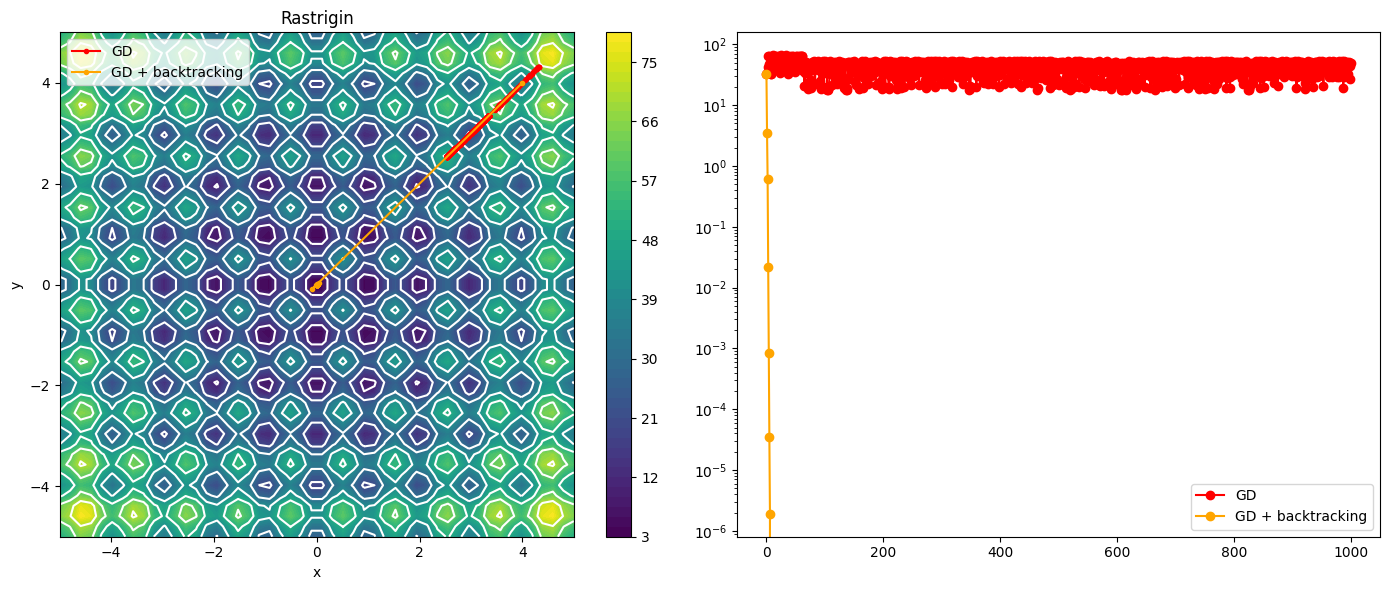

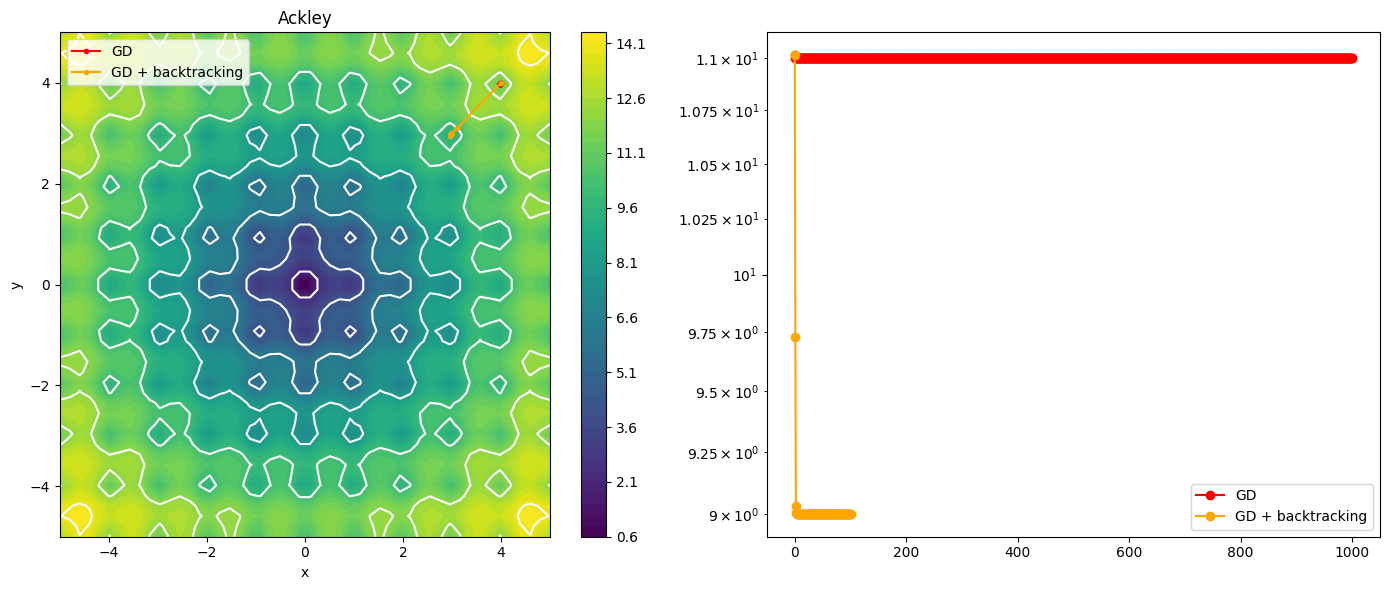

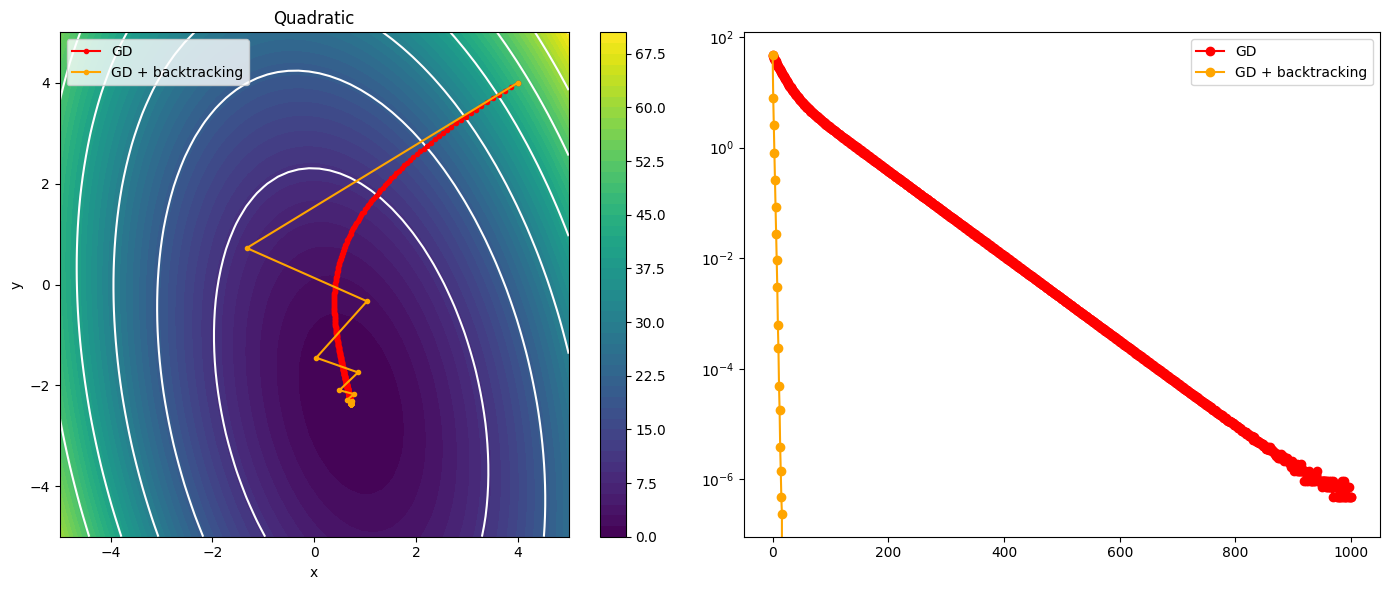

In [ ]:
x0 = jnp.array([4.0, 4.0])

test_functions = [
    (rastrigin, "Rastrigin"),
    (ackley, "Ackley"),
    (quadratic, "Quadratic"),
]

for func, name in test_functions:
    grad_func = jax.jit(jax.grad(func))
    print(f"Testing on {name} function")

    gd_x, gd_path = gradient_descent(grad_func, x0)
    gd_backtrack_x, gd_backtrack_path = gradient_descent_backtracking(func, grad_func, x0)

    plot_optimization_2d(func, gd_path, gd_backtrack_path, title=name)

print(gd_backtrack_path)

### Exact Line Search on Quadratic Function

Using exact line search, we aim to find the optimal path for the **Quadratic function**. This method is specific to quadratic functions and will only be applied to this case.


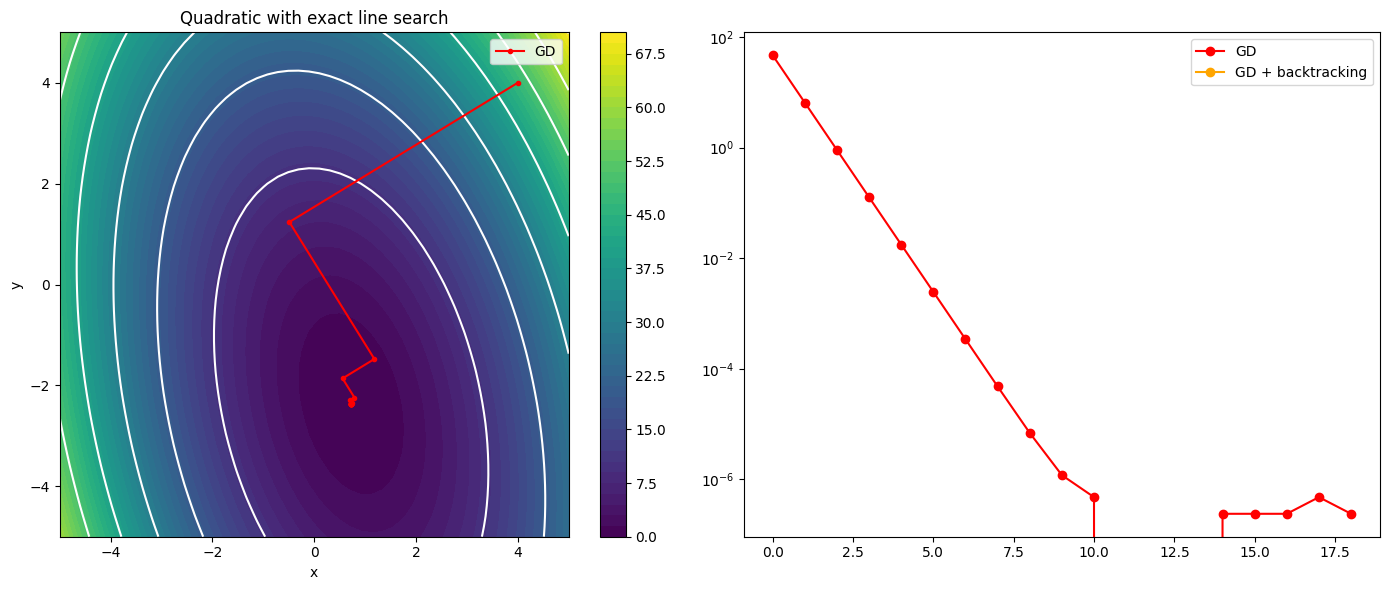

In [27]:
quad_x, quad_path = exact_line_search_quadratic(quadratic_A, quadratic_b, x0)
plot_optimization_2d(quadratic, quad_path, [], title="Quadratic with exact line search")

# Linear Regression using Stochastic Gradient Descent (SDG)

In this laboratory session, we will implement a simple linear regression model using stochastic gradient descent (SGD) to minimize the mean squared error (MSE). The dataset is synthetic, and we will use JAX for efficient computation and automatic differentiation.

### Problem Setup

Given a set of data points $ (x_i, y_i) $, the goal is to learn the parameters $ \theta_0 $ and $ \theta_1 $ such that the model predicts $ y = \theta_0 + \theta_1 x $. We will optimize these parameters using SGD to minimize the MSE loss.


### Generate Synthetic Data

We will generate synthetic data where $ y = 1.5 x + 3 $, with some added Gaussian noise. This data will be used to test our linear regression model.

Let us now generate the synthetic dataset using JAX's random number generation functions.


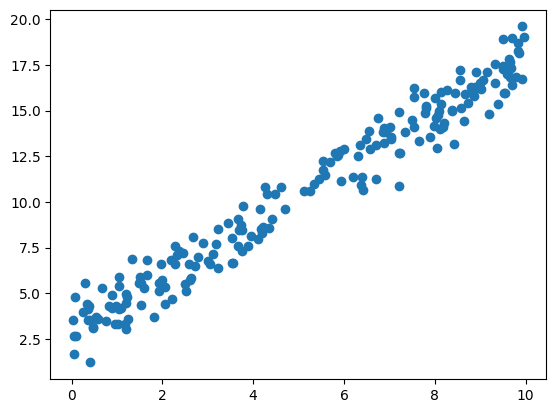

In [28]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

N = 200
X = jax.random.uniform(key, shape = (N,), minval = 0, maxval = 10)
Y = 1.5*X + 3 + jax.random.normal(subkey, shape = (N,))

plt.scatter(X, Y)

In [36]:
train_size = int(0.8 * N)
val_size = N - train_size

key, subkey = jax.random.split(key)
idxs = jax.random.permutation(subkey, N)
train_idxs = idxs[:train_size]
val_idxs = idxs[train_size:]

X_train, y_train = X[train_idxs], Y[train_idxs]
X_val, y_val = X[val_idxs], Y[val_idxs]

### Linear Regression Model

The linear regression model is defined as:

$$ y = \theta_0 + \theta_1 x $$

Where $ \theta_0 $ is the intercept and $ \theta_1 $ is the slope. We will define this model and a loss function to optimize it.


In [29]:
@jax.jit
def model(theta, x):
    return theta[0] * x + theta[1]

### Mean Squared Error (MSE) Loss Function

The loss function we will use is the Mean Squared Error (MSE) between the predicted values and the true values:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

We will also use JAX's `jit` decorator to optimize this function for faster computation.


In [31]:
@jax.jit
def mse_loss(theta, x, y):
    preds = model(theta, x)
    return jnp.mean((preds - y) ** 2)

### Gradient of the Loss Function

We can compute the gradient of the MSE loss function with respect to the parameters $ \theta_0 $ and $ \theta_1 $ using JAX's automatic differentiation. This will allow us to update the parameters using gradient descent.


In [32]:
mse_grad = jax.jit(jax.grad(mse_loss))

### Stochastic Gradient Descent (SGD) Update Step

In Stochastic Gradient Descent (SGD), we update the parameters using the gradient computed on a random mini-batch of the data. This allows for faster convergence compared to using the full dataset at each iteration.

We will define a function to perform a single update step of SGD.


In [34]:
@jax.jit
def sgd_update(theta, x_batch, y_batch, learning_rate):
    grad = mse_grad(theta, x_batch, y_batch)
    return theta - learning_rate * grad

### Stochastic Gradient Descent with Mini-batches

We will implement the full Stochastic Gradient Descent (SGD) algorithm, processing the data in mini-batches. At each epoch, we shuffle the data and update the parameters using the mini-batch gradients.

Let's now define the `stochastic_gradient_descent` function.


In [35]:
# Stochastic Gradient Descent with mini-batches
def stochastic_gradient_descent(
    theta,
    training_input,
    training_labels,
    validation_input,
    validation_labels,
    learning_rate=0.01,
    epochs=100,
    batch_size=10,
    state=0,
):
    key = jax.random.PRNGKey(state)
    for epoch in range(epochs):
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, len(training_input))

        for i in range(0, len(training_input), batch_size):
            batch_idx = perm[i : i + batch_size]
            x_batch = training_input[batch_idx]
            y_batch = training_labels[batch_idx]
            
            theta = sgd_update(theta, x_batch, y_batch, learning_rate)
        if epoch % 10 == 0:
            loss = mse_loss(theta, validation_input, validation_labels)
            print(f"Epoch {epoch}, Validation Loss: {loss:.4f}")
    return theta

### Optimized Parameters

After running the optimization, we will obtain the optimized values of $ \theta_0 $ and $ \theta_1 $. These parameters define the best-fit line for the data.

Let's print the optimized parameters.


In [37]:
# Run the Stochastic Gradient Descent
# Initial guess for theta_0 (intercept) and theta_1 (slope)
theta = jnp.array([0.0, 0.0])

theta_opt = stochastic_gradient_descent(theta, X_train, y_train, X_val, y_val)

Epoch 0, Validation Loss: 2.1430
Epoch 10, Validation Loss: 1.0673
Epoch 20, Validation Loss: 0.8782
Epoch 30, Validation Loss: 1.0864
Epoch 40, Validation Loss: 0.8295
Epoch 50, Validation Loss: 1.1893
Epoch 60, Validation Loss: 1.0600
Epoch 70, Validation Loss: 0.9963
Epoch 80, Validation Loss: 0.9879
Epoch 90, Validation Loss: 0.8283


### Visualizing the Results

Finally, we can plot the original data points and the regression line defined by the optimized parameters.


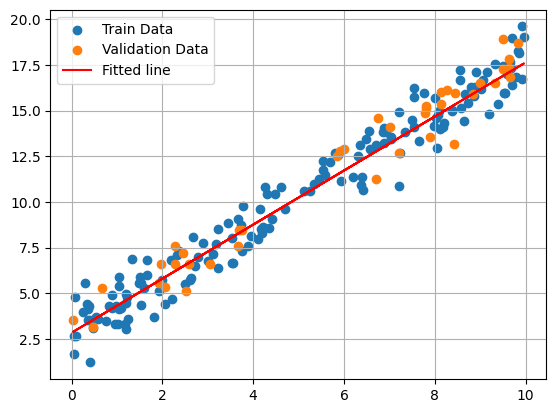

In [39]:
plt.scatter(X_train, y_train, label="Train Data")
plt.scatter(X_val, y_val, label="Validation Data")
plt.plot(X, model(theta_opt, X), color="red", label="Fitted line")
plt.legend()
plt.grid()